In [4]:
import tensorflow as tf
import numpy as np
from cv2 import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import backend as K

tf.get_logger().setLevel('ERROR')

In [5]:
model = tf.keras.models.load_model('./saved_model/128x2_sin_cos_1e-03_fractal')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5248      
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 22,147
Trainable params: 22,147
Non-trainable params: 0
_________________________________________________________________


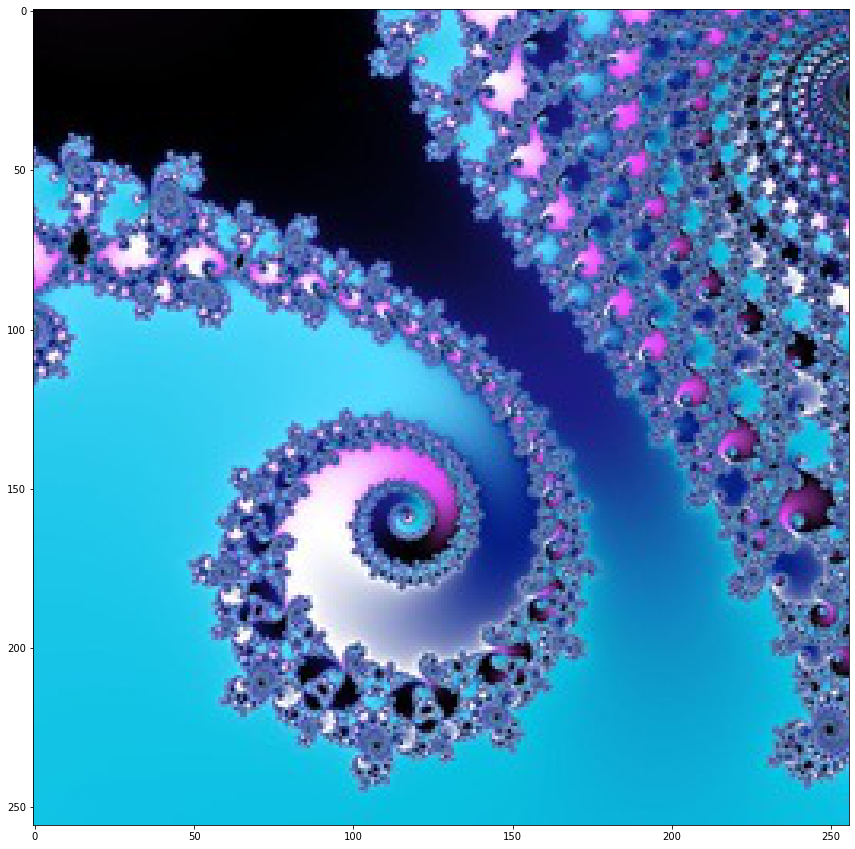

In [6]:
image = Image.open('dataset/fractal.jpg')
image = np.asarray(image)
image = image / 255.0

plt.figure(figsize=(15, 15))
plt.imshow(image)

In [7]:
from NeRF2D import Positional_Encoding

positional_encoding = Positional_Encoding(image, 'sin_cos')
positions, _, indices = positional_encoding.get_dataset(shuffle=False)

output = model(positions, training=False)

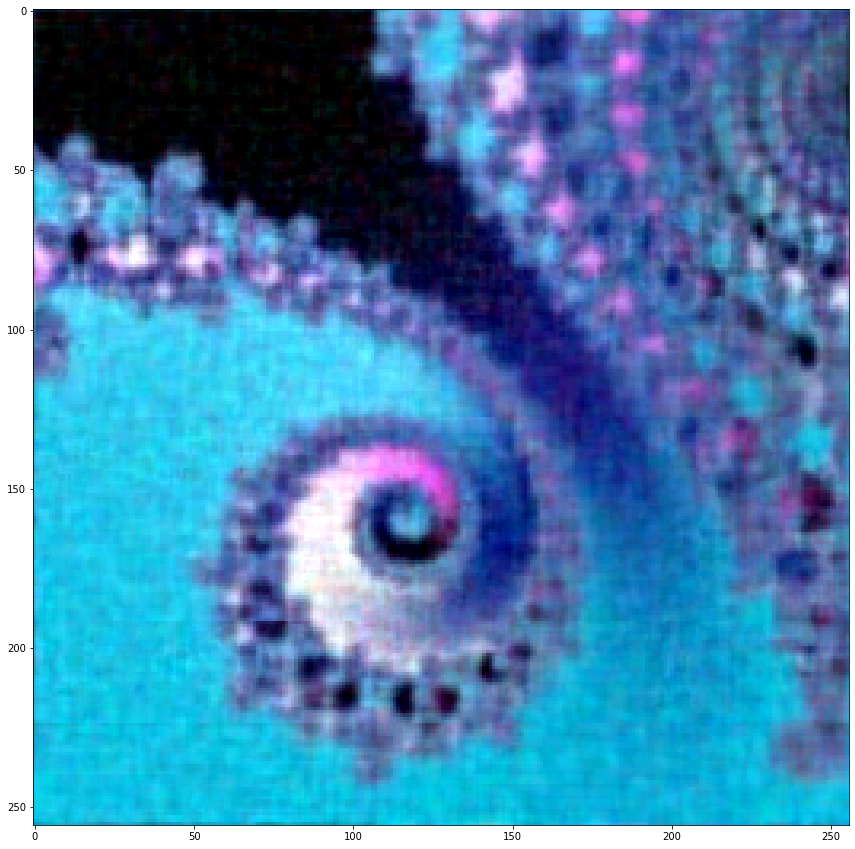

In [8]:
height, width, channels = image.shape
predicted_image = np.zeros((height, width, channels))

indices_int = indices.astype('int')
indices_int = indices_int[:, 1] * width + indices_int[:, 0]

np.put(predicted_image[:, :, 0], indices_int, np.clip((output[:, 0]+1)/2.0, 0, 1))
np.put(predicted_image[:, :, 1], indices_int, np.clip((output[:, 1]+1)/2.0, 0, 1))
np.put(predicted_image[:, :, 2], indices_int, np.clip((output[:, 2]+1)/2.0, 0, 1))

plt.figure(figsize=(15, 15))
plt.imshow(predicted_image)

Amount of unique activation patterns in layer 1: 65221


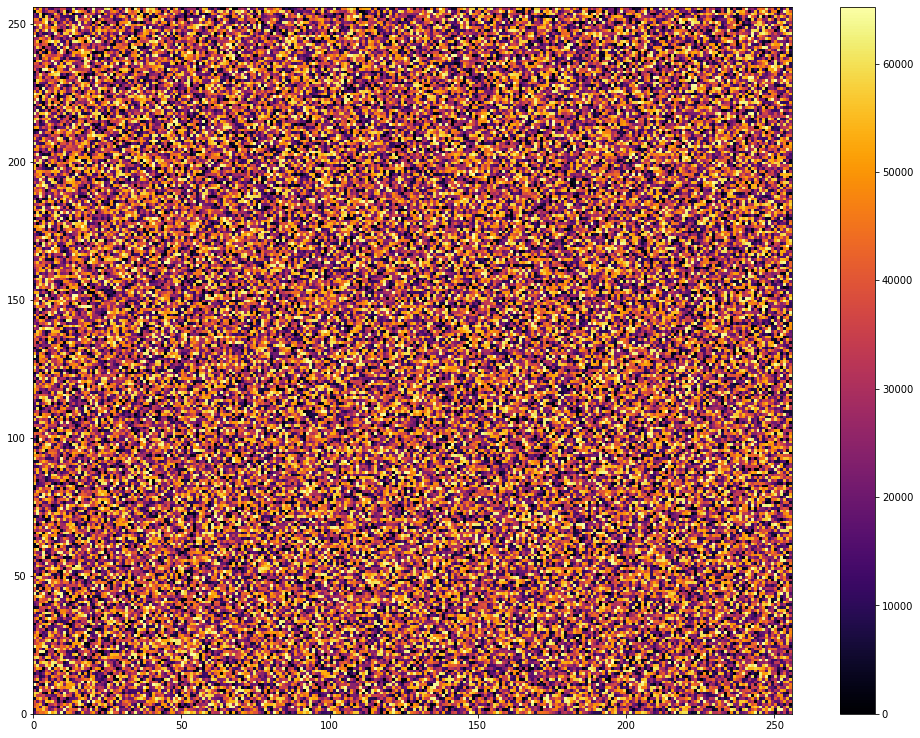

In [9]:
# Get the activations, ignore the last layer
dense1 = K.function([model.input], [model.layers[0].output])
relu1 = K.function([model.input], [model.layers[1].output])
dense2 = K.function([model.input], [model.layers[2].output])
relu2 = K.function([model.input], [model.layers[3].output])

# pass in data to layers
dense1_output = dense1([positions])
dense1_output = np.squeeze(dense1_output)
for i, pixel in enumerate(dense1_output):
    for j, output in enumerate(pixel):
        if output > 0:
            dense1_output[i][j] = 1
        else:
            dense1_output[i][j] = 0

# Get the amount of unique activation regions
input = [tuple(x) for x in dense1_output.tolist()]
unique_patterns = set(input)
print("Amount of unique activation patterns in layer 1: {}".format(len(unique_patterns)))

Dict = {}

# create a dictionary to assign each unique activation a color
activations = [tuple(x) for x in dense1_output.tolist()]
for i, pixel in enumerate(unique_patterns):
	Dict[pixel] = i

# Go through the original data and assign each vector a color instead
for i, pixel in enumerate(activations):
	activations[i] = Dict[pixel]

# Reshape and plot
activations = np.array(activations)
activations = np.reshape(activations, [256, 256])
plt.figure(figsize=(17, 13))
plt.pcolormesh(activations, cmap='inferno')
plt.colorbar()
plt.savefig('shuffled_sin_cos.jpg')